# Predicción de ventas

## Dependencias

In [52]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from varclushi import VarClusHi
from datetime import datetime, date
from scipy import stats

import cufflinks as cf
import seaborn as sns
import matplotlib.pyplot as plt

cf.go_offline()
pd.set_option('display.max_columns',None)

## Lectura de datos

In [2]:
ruta = 'St_sales/superstore_final_dataset (1).csv'
df = pd.read_csv(ruta, encoding_errors='ignore')
df.head()

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,State,Postal_Code,Region,Product_ID,Category,Sub_Category,Product_Name,Sales
0,1,CA-2017-152156,8/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,8/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/6/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O Donnel,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O Donnel,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold N Roll Cart System,22.3680


In [3]:
df.shape, df.drop_duplicates(subset=df.columns[1:]).shape

((9800, 18), (9799, 18))

In [4]:
df.drop_duplicates(subset=df.columns[1:], inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9799 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row_ID         9799 non-null   int64  
 1   Order_ID       9799 non-null   object 
 2   Order_Date     9799 non-null   object 
 3   Ship_Date      9799 non-null   object 
 4   Ship_Mode      9799 non-null   object 
 5   Customer_ID    9799 non-null   object 
 6   Customer_Name  9799 non-null   object 
 7   Segment        9799 non-null   object 
 8   Country        9799 non-null   object 
 9   City           9799 non-null   object 
 10  State          9799 non-null   object 
 11  Postal_Code    9788 non-null   float64
 12  Region         9799 non-null   object 
 13  Product_ID     9799 non-null   object 
 14  Category       9799 non-null   object 
 15  Sub_Category   9799 non-null   object 
 16  Product_Name   9799 non-null   object 
 17  Sales          9799 non-null   float64
dtypes: float

## Definición de variables

In [6]:
fechas = ['Order_Date','Ship_Date']
um = ['Row_ID']
vart = ['Sales']
varc = [v for v in df.columns if v not in um and v not in vart and v not in fechas and df[v].dtype !='object']
vard = [v for v in df.columns if v not in fechas and v not in um and v not in vart and v not in varc]

In [7]:
for v in fechas:
    df[v] = pd.to_datetime(df[v],format='%d/%m/%Y')

In [8]:
df['Días'] = [abs(x.day-y.day) for x,y in zip(df[fechas[0]],df[fechas[1]])]

In [9]:
varc.insert(1,'Días')

## Análisis exploratorio

### Variables continuas

#### Valores nulos

In [10]:
nulos = 1 - df.describe().T[['count']]/len(df)
nulos 

,count
Row_ID,0.000000
Postal_Code,0.001123
Sales,0.000000
Días,0.000000


In [11]:
sm = SimpleImputer(missing_values=np.nan,strategy='most_frequent')
sm.fit(df[varc])

SimpleImputer(strategy='most_frequent')

In [12]:
X = pd.DataFrame(sm.transform(df[varc]),columns=varc)
X[um+vart] = df[um+vart].values
X[vard] = df[vard].values

#### Varianza Nula

In [13]:
vt = VarianceThreshold()
vt.fit(X[varc])

VarianceThreshold()

In [14]:
fuera = [a for a,b in zip(varc,vt.get_support()) if not b]
fuera

[]

### Variables discretas

#### Valores nulos

In [15]:
pd.DataFrame(zip(vard,map(lambda v: 1-len(X[v].dropna())/len(X),vard)),columns=['var','nulos']).set_index('var').sort_values(
    by='nulos',ascending=False)

,nulos
var,
Order_ID,0.0
Ship_Mode,0.0
Customer_ID,0.0
Customer_Name,0.0
Segment,0.0
Country,0.0
City,0.0
State,0.0
Region,0.0


#### Conversión a variables numéricas

In [16]:
for v in vard:
    for a,b in zip(list(X[v].unique()),range(1,len(list(X[v].unique()))+1)):
        X.loc[X[v]==a,v]=b
    X[v] = pd.to_numeric(X[v])

In [17]:
vt = VarianceThreshold()
vt.fit(X[vard])

VarianceThreshold()

In [18]:
fuera = [a for a,b in zip(vard,vt.get_support()) if not b]
fuera

['Country']

In [19]:
vard.remove(fuera[0])

In [20]:
varc = varc + vard

### Multicolinealidad

In [21]:
vc = VarClusHi(X,feat_list=varc).varclus().rsquare.sort_values(by=['Cluster','RS_Ratio'],
                                            ascending=True).reset_index(drop=True)
display(vc)
best = sorted(vc.groupby('Cluster').first()['Variable'])
best

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,Product_Name,0.979449,0.040824,0.021426
1,0,Product_ID,0.979449,0.043803,0.021493
2,1,Postal_Code,0.714250,0.000520,0.285899
3,1,State,0.573263,0.031286,0.440520
4,1,Region,0.547078,0.009831,0.457419
5,2,Customer_ID,0.997499,0.031480,0.002583
6,2,Customer_Name,0.997499,0.031480,0.002583
7,2,Segment,0.010083,0.000693,0.990604
8,3,Category,0.796922,0.001569,0.203397
9,3,Sub_Category,0.796922,0.003927,0.203879


['Category', 'City', 'Customer_ID', 'Postal_Code', 'Product_Name', 'Ship_Mode']

### Selección de variables con mejor poder predictivo

In [22]:
sk = SelectKBest(k=len(varc),score_func=f_regression)
sk.fit(X[varc],X[vart[0]])

SelectKBest(k=14, score_func=<function f_regression at 0x7fd4869a52d0>)

In [23]:
pd.DataFrame(zip(varc,sk.scores_),columns=['var','sk']).set_index('var').sort_values(by='sk',
                                                        ascending=False).iplot(kind='bar',color='orange')

In [24]:
sk = SelectKBest(k=3, score_func=f_regression)
sk.fit(X[varc],X[vart[0]])

SelectKBest(k=3, score_func=<function f_regression at 0x7fd4869a52d0>)

In [25]:
best = [a for a,b in zip(varc,sk.get_support())if b]
best

['Postal_Code', 'Category', 'Product_Name']

### Valores extremos

array([[<AxesSubplot:title={'center':'Postal_Code'}>,
        <AxesSubplot:title={'center':'Category'}>],
       [<AxesSubplot:title={'center':'Product_Name'}>, <AxesSubplot:>]],
      dtype=object)

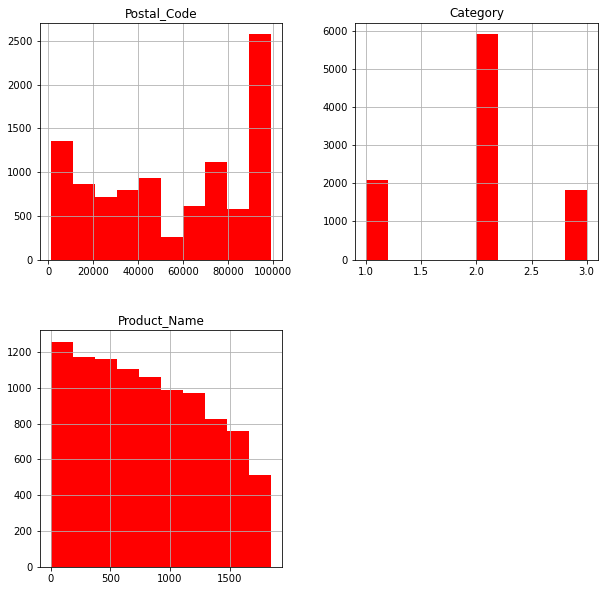

In [26]:
X[best].hist(figsize=(10,10),color='red')

In [27]:
for v,li,ls in X[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X[f'ex_{v}'] = ((X[v]<li)|(X[v]>ls)).astype(int)
X['ex_'] = X.filter(like='ex_').max(axis=1)
X['ex_'].value_counts(1)

0    0.96765
1    0.03235
Name: ex_, dtype: float64

In [28]:
for v,li,ls in X[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X.loc[X[v]<li,v]=np.nan
    X.loc[X[v]>ls,v]=np.nan

In [29]:
sm = SimpleImputer(missing_values=np.nan,strategy='median')
sm.fit(X[best])

SimpleImputer(strategy='median')

In [30]:
Xi = pd.DataFrame(sm.transform(X[best]),columns=best)
Xi[um+vart] = X[um+vart].values

array([[<AxesSubplot:title={'center':'Postal_Code'}>,
        <AxesSubplot:title={'center':'Category'}>],
       [<AxesSubplot:title={'center':'Product_Name'}>, <AxesSubplot:>]],
      dtype=object)

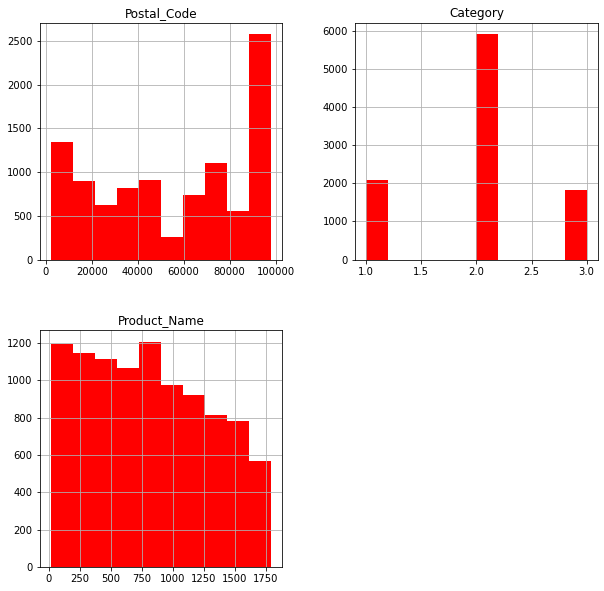

In [31]:
Xi[best].hist(figsize=(10,10),color='red')

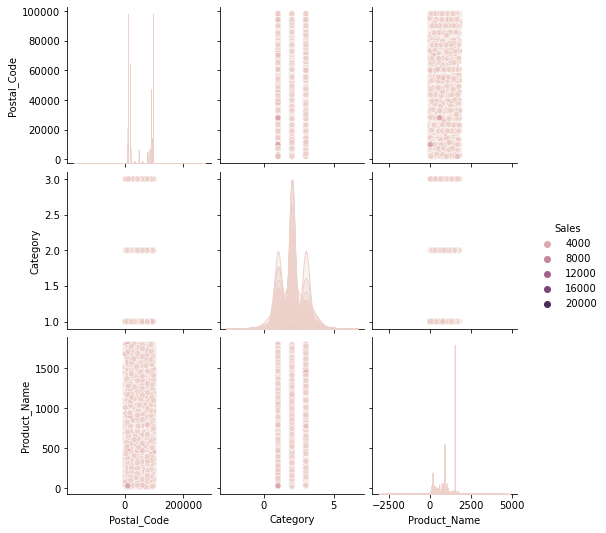

In [32]:
sns.pairplot(Xi[best+vart],hue=vart[0])

### Cambio de espacio $\mathcal{X}_{[0,1]}$

In [53]:
sc = MinMaxScaler()
sc.fit(Xi[best])

MinMaxScaler()

In [54]:
X01 = pd.DataFrame(sc.transform(Xi[best]),columns=best)
X01[um+vart] = Xi[um+vart].values

### Partición de entrenamiento

In [57]:
Xt, Xv = train_test_split(X01[um+best+vart],train_size=0.7)
Xt.reset_index(drop=True,inplace=True)
Xv.reset_index(drop=True,inplace=True)

## Aprendizaje

### Regresión cresta

In [58]:
hp = dict(alpha = np.arange(0.1,3,0.1))

modelo = Ridge()

grid = GridSearchCV(param_grid=hp,
                    cv = 3,
                   scoring='neg_mean_absolute_error',
                   n_jobs=-1,
                   verbose=True,
                   estimator=modelo)

In [59]:
grid.fit(Xt[best],Xt[vart[0]])

Fitting 3 folds for each of 29 candidates, totalling 87 fits


GridSearchCV(cv=3, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9])},
             scoring='neg_mean_absolute_error', verbose=True)

In [60]:
grid.best_params_

{'alpha': 2.9000000000000004}

In [61]:
modelo = grid.best_estimator_
modelo

Ridge(alpha=2.9000000000000004)

In [62]:
modelo.fit(Xt[best],Xt[vart[0]])

Ridge(alpha=2.9000000000000004)

#### Validación del modelo

In [63]:
Xt['y^'] = modelo.predict(Xt[best])
Xv['y^'] = modelo.predict(Xv[best])

In [64]:
print(mean_absolute_error(y_pred=Xt['y^'],y_true=Xt[vart[0]]))
print(mean_absolute_error(y_pred=Xv['y^'],y_true=Xv[vart[0]]))

262.12991631387644
279.5445624383877


In [65]:
print(r2_score(y_pred=Xt['y^'],y_true=Xt[vart[0]]))
print(r2_score(y_pred=Xv['y^'],y_true=Xv[vart[0]]))

0.0017497416593725834
0.003557745393669043


<AxesSubplot:ylabel='Density'>

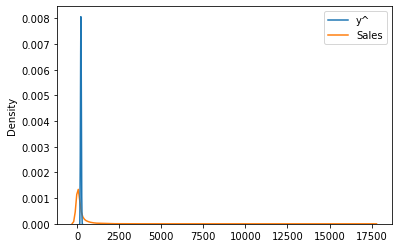

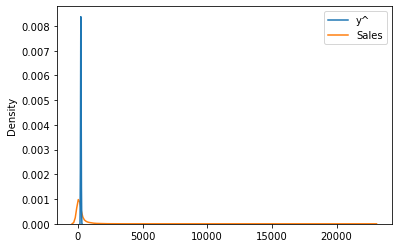

In [66]:
plt.figure()
sns.kdeplot(Xt[['y^']+vart],cbar=True)
plt.figure()
sns.kdeplot(Xv[['y^']+vart],cbar=True)

In [67]:
Xv.head()

,Row_ID,Postal_Code,Category,Product_Name,Sales,y^
0,3754.0,0.918575,0.5,0.056710,841.568,191.135778
1,213.0,0.438770,0.5,0.104436,23.680,212.209100
2,5110.0,0.176990,0.5,0.254913,52.512,230.549337
3,4400.0,0.196893,0.5,0.487928,199.900,242.597278
4,7228.0,0.176990,1.0,0.421112,1319.800,260.513392


### Regresión Lineal

In [68]:
modelo = LinearRegression(n_jobs=-1)
modelo.fit(Xt[best],Xt[vart[0]])

LinearRegression(n_jobs=-1)

In [69]:
modelo.coef_

array([-38.60426005,  41.81739988,  55.29212871])

#### Validación del modelo

In [70]:
Xt['y^'] = modelo.predict(Xt[best])
Xv['y^'] = modelo.predict(Xv[best])

In [71]:
print(mean_absolute_error(y_pred=Xt['y^'],y_true=Xt[vart[0]]))
print(mean_absolute_error(y_pred=Xv['y^'],y_true=Xv[vart[0]]))

262.13522905129497
279.54748917543117


In [72]:
print(r2_score(y_pred=Xt['y^'],y_true=Xt[vart[0]]))
print(r2_score(y_pred=Xv['y^'],y_true=Xv[vart[0]]))

0.0017497796167750268
0.0035702184501670287


<AxesSubplot:ylabel='Density'>

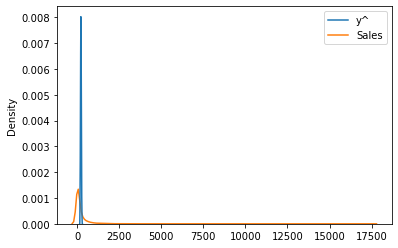

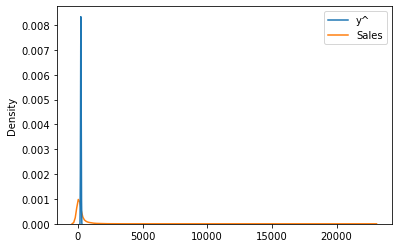

In [73]:
plt.figure()
sns.kdeplot(Xt[['y^']+vart],cbar=True)
plt.figure()
sns.kdeplot(Xv[['y^']+vart],cbar=True)

In [74]:
Xv.head()

,Row_ID,Postal_Code,Category,Product_Name,Sales,y^
0,3754.0,0.918575,0.5,0.056710,841.568,190.963759
1,213.0,0.438770,0.5,0.104436,23.680,212.125162
2,5110.0,0.176990,0.5,0.254913,52.512,230.551201
3,4400.0,0.196893,0.5,0.487928,199.900,242.666769
4,7228.0,0.176990,1.0,0.421112,1319.800,260.649385


In [75]:
Xv[vart[0]].sum(),Xv['y^'].sum()

(710995.3535, 663499.9678358163)